## Setup

In [2]:
import os
import math
import numpy as np
import pandas as pd
from ast import literal_eval
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

## Prepare the data

In [ ]:
# Download the data
!gdown https://drive.google.com/uc?id=1eaMKyV3D4sF32NJkh6VbTF1pTYZ-FwJu
!gdown https://drive.google.com/uc?id=1t4RPl8vp4jtU--HYTcBawbD7nibfOldf

In [ ]:
ratings = pd.read_csv('/content/ratings_small.csv')
movies = pd.read_csv('/content/movies_metadata.csv')

Drop irrelevant columns in the 'movies' dataset

In [9]:
selected_columns = ['genres', 
                    'id', 
                    'original_language', 
                    'overview', 
                    'production_companies',
                    'production_countries', 
                    'tagline', 
                    'vote_average', 
                    'vote_count', 
                    'title']
movies = movies[selected_columns].dropna().copy()

In [11]:
movies['genres'] = movies['genres'].apply(literal_eval).apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])

In [12]:
movies['production_companies'] = movies['production_companies'].apply(literal_eval).apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])

In [13]:
movies['production_countries'] = movies['production_countries'].apply(literal_eval).apply(lambda x : [i['name'] for i in x] if isinstance(x, list) else [])

Each movie has multiple genres. We split them into separate columns in the `movies` DataFrame.

In [15]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values)
    )

## Transform the movie ratings data into sequences

Simple data processing to fix the data types of the columns.

In [18]:
movies["id"] = movies["id"].apply(lambda x: f"movie_{x}")

ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")
ratings["userId"] = ratings["userId"].apply(lambda x: f"user_{x}")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [19]:
ratings_group = ratings.sort_values(by=["timestamp"]).groupby("userId")

ratings_data = pd.DataFrame(
    data={
        "user_id"    : list(ratings_group.groups.keys()),
        "movie_id"   : list(ratings_group.movieId.apply(list)),
        "ratings"    : list(ratings_group.rating.apply(list)),
        "timestamps" : list(ratings_group.timestamp.apply(list)),
    }
)

In [21]:
sequence_length = 4
step_size = 2

def create_sequences(values, window_size, step_size):
  sequences = []
  start_index = 0
  while True:
    end_index = start_index + window_size
    seq = values[start_index : end_index]
    if len(seq) < window_size:
      seq = values[-window_size:]
      if len(seq) == window_size:
        sequences.append(seq)
      break
    sequences.append(seq)
    start_index += step_size
  return sequences


ratings_data.movie_id = ratings_data.movie_id.apply(
    lambda ids : create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids : create_sequences(ids, sequence_length, step_size)
)

del ratings_data['timestamps']

In [22]:
ratings_data_movies = ratings_data[["user_id", "movie_id"]].explode(
    "movie_id", ignore_index = True
)
ratings_data_rating = ratings_data[["ratings"]].explode(
    "ratings", ignore_index = True
)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating],
                                     axis=1)
ratings_data_transformed.movie_id = ratings_data_transformed.movie_id.apply(
    lambda x: ",".join(x)
)
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)

ratings_data_transformed.rename(
    columns = {"movie_id": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace = True,
)

In [24]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("/content/train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("/content/test_data.csv", index=False, sep="|", header=False)


## Define metadata

In [25]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(ratings.userId.unique()),
    "movie_id": list(movies.id.unique()),
}

MOVIE_FEATURES = ["genres"]

## Create `tf.data.Dataset` for training and evaluation

In [26]:
def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset

## Create model inputs

In [27]:
def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
    }

## Encode input features

In [28]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_movie_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token='0', num_oov_indices=1)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token='0',
        num_oov_indices=1,
        oov_token='<OOV>',
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",
    )
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",
    )
    # Create a processing layer for genres.
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",
    )

    ## Define a function to encode a given movie id.
    def encode_movie(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## Encoding target_movie_id
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## Encoding sequence movie_ids.
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=movie_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    )

    # Construct the transformer inputs.
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )

    return encoded_transformer_features, encoded_other_features


## Create a BST model

In [29]:
include_user_id = True
include_movie_features = True

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3


def create_model():
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_movie_features
    )

    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer block.
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    # Included the other features.
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()

## Run training and evaluation experiment

In [ ]:
# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)

# Read the training data.
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Read the test data.
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)

# Fit the model with the training data.
history = model.fit(train_dataset,
          epochs=50,
          validation_data=test_dataset)

# Evaluate the model on the test data.
_, rmse = model.evaluate(test_dataset, verbose=1)
print(f"Test MAE: {round(rmse, 3)}")

In [31]:
history_dict = history.history

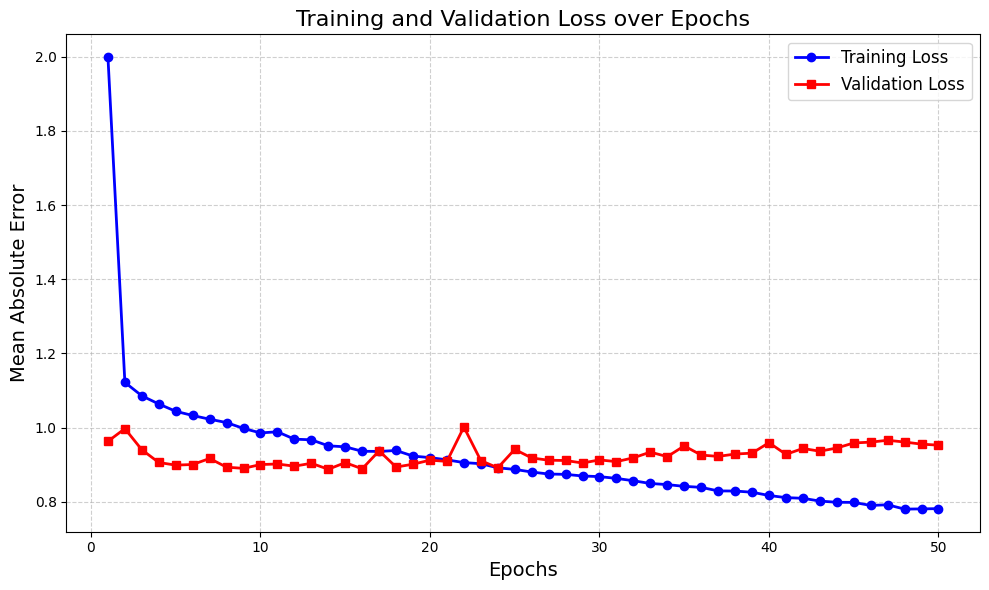

In [37]:
import matplotlib.pyplot as plt

mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss, marker='o', linestyle='-', linewidth=2, markersize=6, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, marker='s', linestyle='-', linewidth=2, markersize=6, color='red', label='Validation Loss')

plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig('MAE_plot_1.png', dpi=300)
plt.show()


<Figure size 640x480 with 0 Axes>

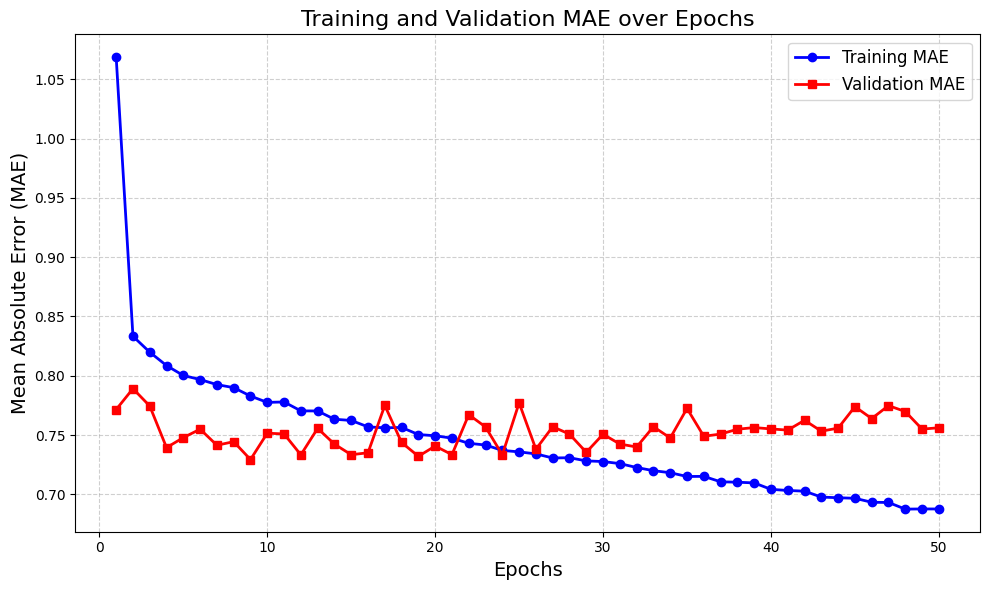

In [35]:
plt.clf()   # clear figure

plt.figure(figsize=(10, 6))

plt.plot(epochs, mae, marker='o', linestyle='-', linewidth=2, markersize=6, color='blue', label='Training MAE')
plt.plot(epochs, val_mae, marker='s', linestyle='-', linewidth=2, markersize=6, color='red', label='Validation MAE')

plt.title('Training and Validation MAE over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig('MAE_plot_2.png', dpi=300)
plt.show()

plt.show()